# Swing prediction: models

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to chasing pitches out of the strike zone. Here, I'll look to predict when a batter will swing the bat using features examined in the *swing_prediction_eda* notebook.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I'll look at a variety of models for binary classification, specifically logistic regression, support vector machines, and random forest. I'll use features related to pitch trajectory/location and game situation, as examined in the *swing_prediction_eda* notebook. I'll focus on making a model for one player, specifically Jack Cust. The techniques examined here can be applied to other individual batters.

## Loading data and creating the response

I'll start by loading information from where a given batter is hitting. For these tests, I'll start with Jack Cust, who was known for three things: hitting home runs, walks, and striking out. I'll create the response (swing or no swing) as well.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [88]:
# import classes
sys.path.append('../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()
# grab player table
query = """SELECT *
        FROM players"""
players = pd.read_sql_query(query, db)

In [104]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

In [105]:
# percentage of swings
print("percentage of pitches swung at: ", np.mean(jc_pitches['swing']))

percentage of pitches swung at:  0.381352541016


Cust swings at less than half the pitches he sees. Specifically, he swings at 38% of the pitches he sees, which could be the baseline error rate for this problem.

## Feature engineering

To create the initial feature matrix, I will include all columns of data from the dataset, organized by pitch. Thus, I'll need to join multiple tables related to games, events, players, and pitchfx.

In [122]:
# join four tables
features = jc_pitches.merge(jc_events,
                     left_on=['game_id', 'cur_event'],
                     right_on=['game_id', 'event_id'],
                     how='left',) \
              .merge(jc_games,
                     left_on=['game_id'],
                     right_on=['game_id'],
                     how='left',) \
              .merge(players[['player_id', 'throws']].drop_duplicates(),
                     left_on=['pitcher_id'],
                     right_on=['player_id'],
                     how='left',) \
              .sort_values(by=['game_id', 'cur_event'])

# print column names
print(features.columns)

Index(['index', 'game_id', 'pitch_num', 'at_bat', 'time', 'cur_event',
       'description', 'outcome', 'pre_balls', 'post_balls', 'pre_strike',
       'post_strike', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x',
       'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir',
       'spin_rate', 'pitch_type', 'swing', 'event_id', 'event_description',
       'inning', 'is_top_inning', 'pre_out', 'post_out', 'pitcher_id',
       'batter_id', 'pre_1b', 'post_1b', 'pre_2b', 'post_2b', 'pre_3b',
       'post_3b', 'post_home', 'pre_home_score', 'post_home_score',
       'pre_away_score', 'post_away_score', 'game_type', 'date', 'game_time',
       'home_id', 'home_wins', 'home_losses', 'visit_id', 'visit_wins',
       'visit_losses', 'stadium_id', 'umpire_home', 'umpire_first',
       'umpire_second', 'umpire_third', 'player_id', 'throws'],
      dtype='object')


While there are many features, I am currently only interested in those related to pitch trajectory/location and game situation. There are a number of features that are very unlikely to help predict whether a batter swings at a pitch or not. For instance, any features related to bookkeeping could be dropped, such as game ids and event ids. Additionally, features related to future events relative to the situation in question (e.g., final score of the game) should be removed.

There are also features that identify people/things that I will drop (such as umpire ids and stadium ids), as expressing these categorical variables through approaches like one-hot encoding can greatly increase the number of features. While this information could be useful, the sample sizes of each category of these features is likely small for each batter.

In [123]:
# drop columns
dropped_indices = ['index', 'game_id', 'cur_event', 'outcome', 'post_balls', 'post_strike', 'sz_top', 'sz_bot',
                   'y0', 'event_id', 'description', 'event_description', 'post_1b', 'post_2b', 'post_3b', 'post_home',
                   'post_home_score', 'post_away_score', 'game_type', 'game_time', 'home_id', 'visit_id', 'umpire_home',
                   'umpire_first', 'umpire_second', 'umpire_third', 'player_id', 'post_out', 'batter_id', 'pitch_type',
                   'date', 'stadium_id', 'home_wins', 'home_losses', 'visit_wins', 'visit_losses', 'pitcher_id',
                   'at_bat', 'pitch_num']

features = features.drop(dropped_indices, axis=1)

I'll adjust pitcher handedness to be binary variable rather than a categorical swing variable, as *sklearn's* packages expect all columns to be numerical values.

In [124]:
# pitcher handedness (0: left, 1: right)
features['throws'].replace(['L', 'R'], [0, 1], inplace=True)

In addition to these features, I'll engineer features that describe the previous pitch and the outcome. In addition to using the raw shifted pitch trajectory/location information, I will calculate the difference in those values relative to the current pitch; in other words, I will calculate the gradient. I will also include whether the batter swung at the previous pitch or not. Note this is trickier than just shifting the rows in our feature matrix down, as I had previously removed pitches that were Nans. As a result, a number of pitches are not actually in sequence (beside those that were from the previous at bat or even previous game). Therefore, I'll return to the original pitch information. Note I will fill in missing values with the mean of the values for that feature (or assume no swing for the swing feature).

In [125]:
# pitch information to calculate gradients of
grad_f = ['start_speed', 'end_speed', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0',
          'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate']
for ff in grad_f:
    features['grad_%s' %(ff)] = -features[ff].diff(1)
for ff in grad_f:
    features['prev_%s' %(ff)] = features[ff].shift(1)
    
# get previous pitch swing information
features['prev_swing'] = features['swing'].shift(1)
features['prev_swing'] = features['prev_swing'].fillna(False)
    
# impute nans with column means
features = features.fillna(features.mean())

I'll also include score differential and ball-strike count differential at the time of the pitch, even though they are linear combinations of existing features.

In [126]:
# score differential (relative to batter's team)
score_diff = features['pre_home_score']-features['pre_away_score']
score_diff[features['is_top_inning']==True] = -score_diff[features['is_top_inning']==True]
features['score_diff'] = score_diff

# ball-strike differential
features['count_diff'] = features['pre_balls']-features['pre_strike']

In [127]:
# print column names
print(features.columns)

Index(['time', 'pre_balls', 'pre_strike', 'start_speed', 'end_speed', 'pfx_x',
       'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0', 'vy0', 'vz0', 'ax',
       'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir',
       'spin_rate', 'swing', 'inning', 'is_top_inning', 'pre_out', 'pre_1b',
       'pre_2b', 'pre_3b', 'pre_home_score', 'pre_away_score', 'throws',
       'grad_start_speed', 'grad_end_speed', 'grad_pfx_x', 'grad_pfx_z',
       'grad_px', 'grad_pz', 'grad_x', 'grad_y', 'grad_x0', 'grad_z0',
       'grad_vx0', 'grad_vy0', 'grad_vz0', 'grad_ax', 'grad_ay', 'grad_az',
       'grad_break_y', 'grad_break_angle', 'grad_break_length',
       'grad_spin_dir', 'grad_spin_rate', 'prev_start_speed', 'prev_end_speed',
       'prev_pfx_x', 'prev_pfx_z', 'prev_px', 'prev_pz', 'prev_x', 'prev_y',
       'prev_x0', 'prev_z0', 'prev_vx0', 'prev_vy0', 'prev_vz0', 'prev_ax',
       'prev_ay', 'prev_az', 'prev_break_y', 'prev_break_angle',
       'prev_break_length', 'prev_spin_

I will use these features, which are representative of game situation, current pitch trajectory/location, and previous pitch trajectory/location, for my models.

## Random forest

Random forest has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability.

In [ ]:
# import
import sys
sys.path.append('../src')
from split_data import split_data

### All features

I'll begin by using all features. The first step is to divide the dataset into a training set and a test set. Here, I will start by taking randomly taking 70% of the data to be the training set and the remaining 30% of the data to be the test set.

In [128]:
# creating training and test sets
y = features['swing'].astype('int')
features = features.drop('swing', axis=1)
X_train, X_test, y_train, y_test = split_data(features, y, 0.7, 0)

I'll check the distribution of swings and not swings between the training and test sets to check if they're similar to the full training set. Note that these will also be the baseline errors (guessing a non-swing for every pitch).

In [129]:
# percentage of swings and not swings
print("percentage of pitches swung at in training set: ", np.mean(y_train.values))
print("percentage of pitches swung at in test set: ", np.mean(y_test.values))

percentage of pitches swung at in training set:  0.383188405797
percentage of pitches swung at in test set:  0.377260981912


With the distribution of swings are similar between the two sets, I can perform random forest classification.

In [130]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 0
nestimators = 1000

# initialize classifiers
rf1_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X_train, y_train)

For validating my model, I will look to examine the out-of-bag error, which is similar to cross-validation error. In random forest, a number of decision trees are built on bootstrapped data. Therefore, each tree is likely to leave out a subset of the training data. One can predict the reponse for each data point using results from trees where the data point was not used to build the tree (OOB). The final prediction for each data point is just the majority vote amongst total predictions (in the classification problem). I'll also provide the error on the test set.

In [ ]:
# out-of-bag error
print("out-of-bag error: ", 1-rf1_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf1_fit.predict(X_test)==y_test))

The errors are significantly lower than guessing a non-swing every pitch, which is a promising sign.

I'll now take a look at the feature importance from the random forest model by adding up the total amount that the Gini index is decreased by splits over a given feature, averaged over all trees and normalized. I'll sort features by importance.

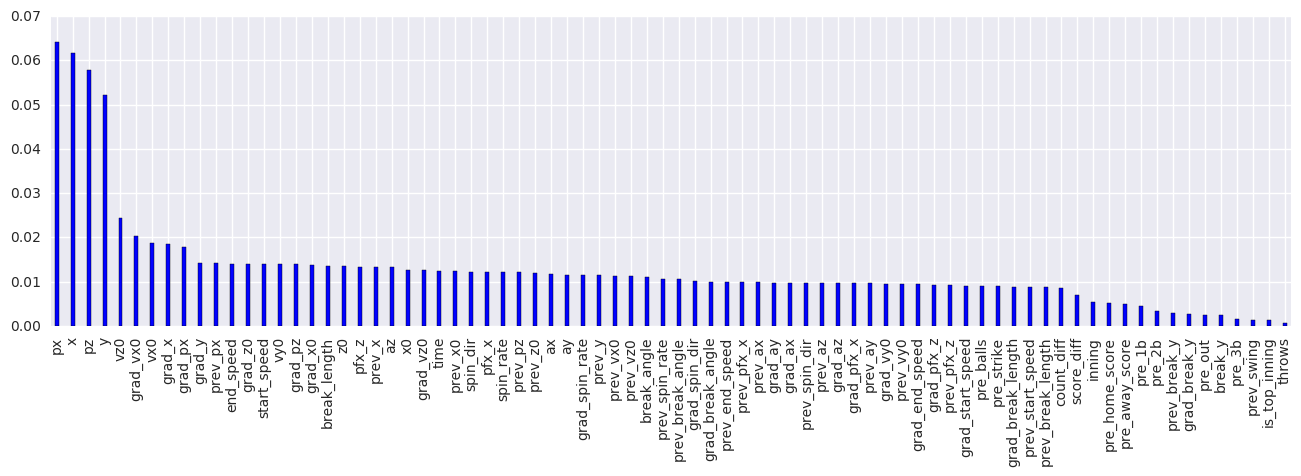

In [142]:
# feature importance plot
importance = pd.Series(rf1_fit.feature_importances_,
                       index=X_train.columns)
indices = np.argsort(importance)[::-1]
importance[indices].plot.bar(color='blue', width=0.25, figsize=(16, 4))
plt.show()

As expected, the pitch location in the strike zone is relatively important (`px`, `pz`, `x`, `y`), as most batters are more likely to swing when the pitch is in the zone. The initial velocity and the difference in pitch location relative to the previous at-bat appear to be the next most important features.

Note that random forest feature importance is biased towards features with more values/levels. This is observed here, where many of the binary features appear to have the least importance.

Overall, many features appear to have similar importance (outside of the pitch location and the initial velocities out of the hand). Therefore, I'll look to remove some features to reduce noise in the data set, which in turn may improve the model.

### Add situational features

In the current feature matrix, there is only information that describe the pitch trajectory and the pitch location. Here, I'll add situational features.

I'll add the current count in the at-bat. For now, I will treat balls and strikes as independent (separate features).

In [223]:
# copy features matrix
X2 = X1.copy()

# add count information
X2['pre_balls'] = jc_pitches['pre_balls']
X2['pre_strikes'] = jc_pitches['pre_strike']

Next, I'll add the base running situation. I will treat each bases as independent, with a value of 1 is there is a runner on and value of 0 if there is not a runner on.

In [224]:
# construct pitches and events in same table
extras = jc_pitches.merge(jc_events,
                          left_on=['game_id', 'cur_event'],
                          right_on=['game_id', 'event_id'],
                          how='left')

In [225]:
# runners in scoring position
runners = extras[['pre_2b', 'pre_3b']].copy()
runners[runners>0] = 1

# append to dataframe
X2 = pd.concat([X2, runners], axis=1)

Next, I'll add the number of outs in the inning, as well as the inning.

In [226]:
# outs
X2['outs'] = extras['pre_out']

# inning
X2['inning'] = extras['inning']

I'll also add the score of the game, with negative values indicating the batter's team is behind and positive values indicating the batter's team is ahead.

In [227]:
# score differential
score_diff = extras['pre_home_score']-extras['pre_away_score']
score_diff[extras['is_top_inning']==True] = -score_diff[extras['is_top_inning']==True]
X2['score_diff'] = score_diff
X2['away'] = extras['is_top_inning']

With these simple situational features, I'll run random forest again.

In [228]:
# split data into training and test sets
X2_train, X2_test, y_train, y_test = split_data(X2, y, 0.7, 0)

In [229]:
# initialize classifiers
nestimators = 1000
seed = 0
rf2_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X2_train, y_train)

In [230]:
# out-of-bag error
print("out-of-bag error: ", 1-rf2_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf2_fit.predict(X2_test)==y_test))

out-of-bag error:  0.222028985507
test error:  0.220930232558


The OOB error is smaller than the original model, but the test error is slightly larger. Therefore, it doesn't appear that the situational features are helping improve the model much. 

I'll look at the feature importances now.

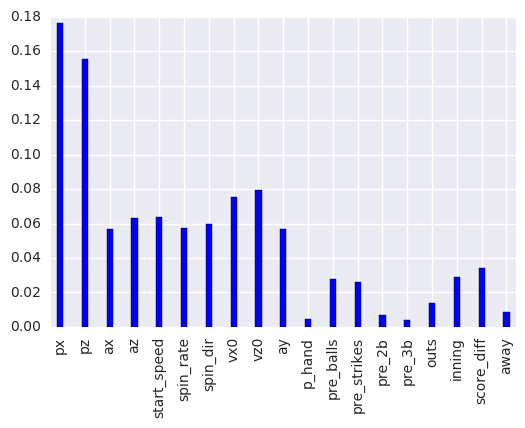

In [231]:
# calculate feature importance
importance = pd.Series(rf2_fit.feature_importances_,
                       index=X2.columns)
importance.plot.bar(color='blue', width=0.25)
plt.show()

Again, the feature importance estimates seem to be biased by the number of values a feature can have. For instance, the binary features (`p_hand`, `pre_1b`, `pre_2b`, `pre_3b`, and `away`) all have low importance.

### Previous pitch features

The pitch information and result of the previous throw can potentially provide more information about whether the batter swings on this pitch or not. Here, I'll create features related to the previous pitch.

First, I'll grab the location and pitch trajectory features from the previous pitch. This is trickier than just shifting the rows in our feature matrix down, as I had previously removed pitches that were Nans. As a result, a number of pitches are not actually in sequence (beside those that were from the previous at bat or even previous game). Therefore, I'll return to the original pitch information.

In [232]:
# grab all pitches shifted including nans
jc_pitches_nans = jc.pitches_against().shift(1)

# grab pitches that are in the cleaned dataset
indices = jc_pitches['index']
next_pitches = jc_pitches_nans.iloc[indices, :].reset_index()

In [234]:
# copy features
X3 = X2.copy()

# previous pitch features
#X3['prev_px'] = next_pitches['px']
#X3['prev_pz'] = next_pitches['pz']
#X3['prev_ax'] = next_pitches['ax']
#X3['prev_az'] = next_pitches['az']
#X3['prev_spin_rate'] = next_pitches['spin_rate']
#X3['prev_spin_dir'] = next_pitches['spin_dir']
X3['prev_px'] = -X2['px'].diff(1)
X3['prev_pz'] = -X2['pz'].diff(1)
X3['prev_ax'] = -X2['ax'].diff(1)
X3['prev_az'] = -X2['az'].diff(1)
X3['prev_spin_rate'] = -X2['spin_rate'].diff(1)
X3['prev_spin_dir'] = -X2['spin_dir'].diff(1)
X3['prev_vx0'] = -X2['vx0'].diff(1)
X3['prev_vz0'] = -X2['vz0'].diff(1)
X3['prev_ay'] = -X2['ay'].diff(1)

# impute nans with means
X3 = X3.fillna(X3.mean())

# get previous pitch swing information
X3['prev_swing'] = y.shift(1)
X3.loc[0, 'prev_swing'] = 0

In [235]:
# split data into training and test sets
X3_train, X3_test, y_train, y_test = split_data(X3, y, 0.7, 0)

In [236]:
# initialize classifiers
nestimators = 1000
seed = 0
rf3_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X3_train, y_train)

In [237]:
# out-of-bag error
print("out-of-bag error: ", 1-rf3_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf3_fit.predict(X3_test)==y_test))

out-of-bag error:  0.233043478261
test error:  0.206718346253


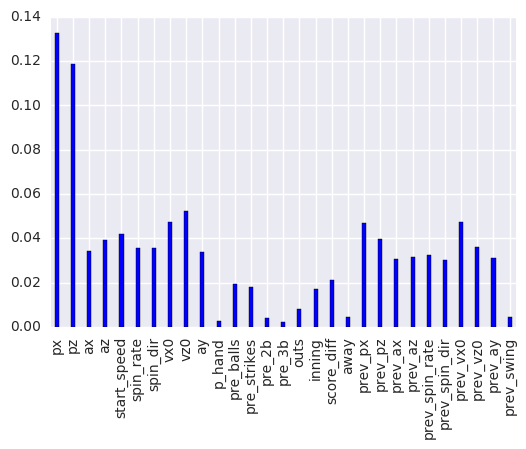

In [238]:
# calculate feature importance
importance = pd.Series(rf3_fit.feature_importances_,
                       index=X3.columns)
importance.plot.bar(color='blue', width=0.25)
plt.show()

## Model evaluation

In [143]:
# imports
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, rf1_fit.predict_proba(X_test)[:, 1])

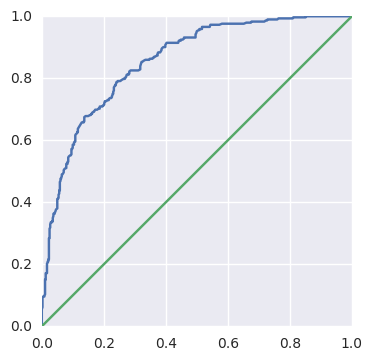

In [144]:
fig, ax = plt.subplots()
ax.plot(fpr_grd_lm, tpr_grd_lm)
ax.plot([0, 1], [0, 1])
#ax.set_xlim(-0.01 ,1.01)
#ax.set_ylim(-0.01 ,1.01)
ax.set_aspect('equal', 'box')

In [145]:
roc_auc_score(y_test, rf1_fit.predict_proba(X_test)[:, 1])

0.8552584834877508

# Naive bayes

In [ ]:
# import
from sklearn.naive_bayes import GaussianNB

# velocity errors
nb_fit = GaussianNB().fit(X_train, y_train)
print("naive bayes test error: ", 1-np.mean(nb_fit.predict(X_test)==y_test))